In [1]:
import lsst.daf.butler as dafButler
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import pickle
import numpy as np


In [2]:
butler = dafButler.Butler("../data")

In [3]:
fakes = butler.get("DEEP_fakes", collections="DEEP/fakes").asAstropy()

In [4]:
def get_patches(visits):
    return list(set(butler.registry.queryDimensionRecords(
        "patch", where="skymap='discrete' and instrument='DECam' and visit IN (" + ",".join(map(str, visits)) + ")"
    )))

def get_visit_numbers(refs):
    return list(set([ref.dataId['visit'] for ref in refs]))


def get_visits(visits):
    return list(set(butler.registry.queryDimensionRecords(
        "visit", where="skymap='discrete' and instrument='DECam' and visit IN (" + ",".join(map(str, visits)) + ")"
    )))


In [7]:
tno_fakes = fakes[fakes['type'] == 'tno']

In [4]:
mba_fakes = fakes[fakes['type'] == 'asteroid']

In [162]:
pg="DEEP/20190403/A0c"
snr="5"
ccd="5"
refs = list(butler.registry.queryDatasets(
    "differenceExp", collections=[pg], where=f"instrument='DECam' and detector={ccd}"
))
visits = get_visit_numbers(refs)

In [165]:
with open(f"../search/{pg}/detector_{ccd}/snr_{snr}/search.pkl", "rb") as fd:
    search = pickle.load(fd)
    
with open(f"../search/{pg}/detector_{ccd}/snr_{snr}/catalog.pkl", "rb") as fd:
    catalog = pickle.load(fd)

In [58]:
# search.hough.X[search.results[0].close]

In [11]:

mask = np.any([mba_fakes['EXPNUM'] == v for v in visits], axis=0)
mask &= (mba_fakes['CCDNUM'] == int(ccd))

In [12]:
pg_fakes = mba_fakes[mask]
len(pg_fakes)

1164

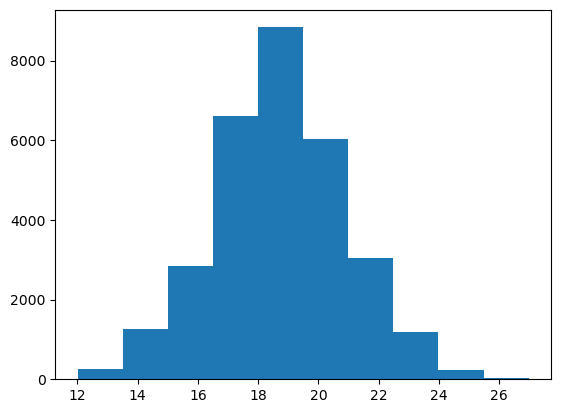

In [16]:
plt.hist(set(mba_fakes['H_VR']))
plt.show()

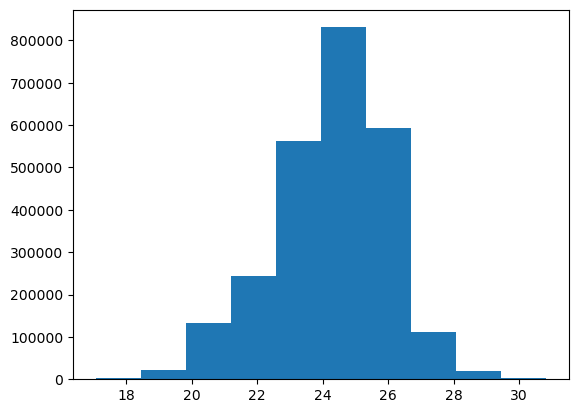

In [203]:
plt.hist(set(mba_fakes['MAG']))
plt.show()

In [5]:
d = np.unique(mba_fakes['MAG'])

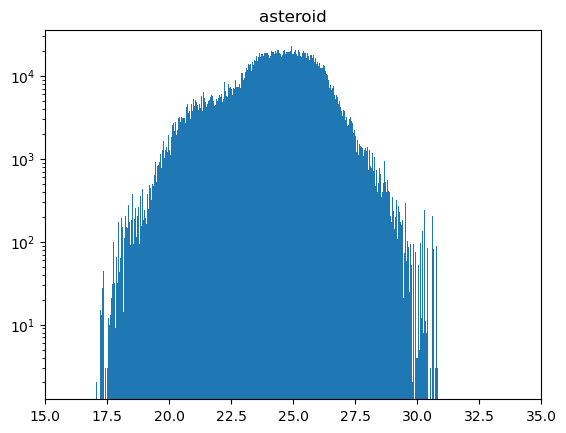

In [15]:
plt.hist(np.unique(mba_fakes['MAG']), bins='auto')
plt.xlim(15, 35)
plt.yscale("log")
plt.title("asteroid")
plt.show()

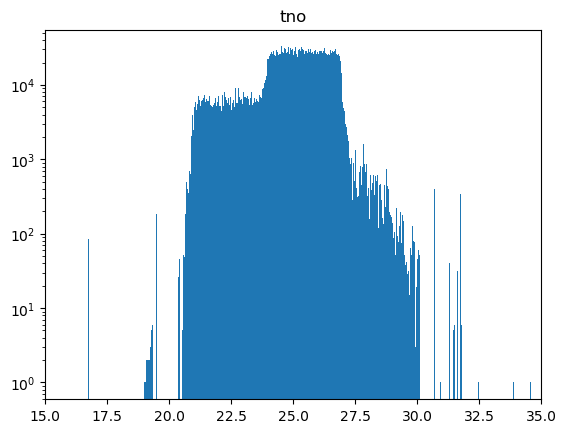

In [14]:
plt.hist(np.unique(tno_fakes['MAG']), bins='auto')
plt.xlim(15, 35)
plt.yscale("log")
plt.title("tno")
plt.show()

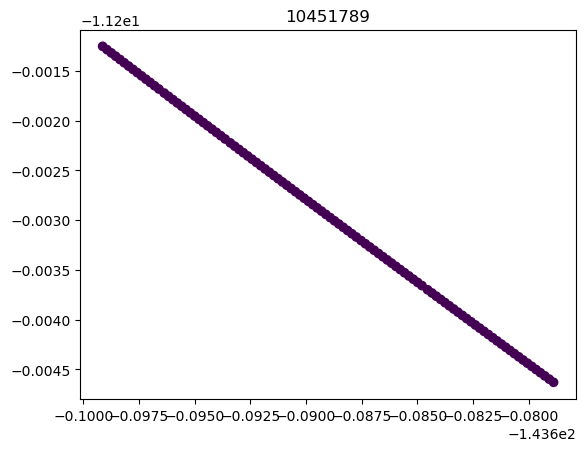

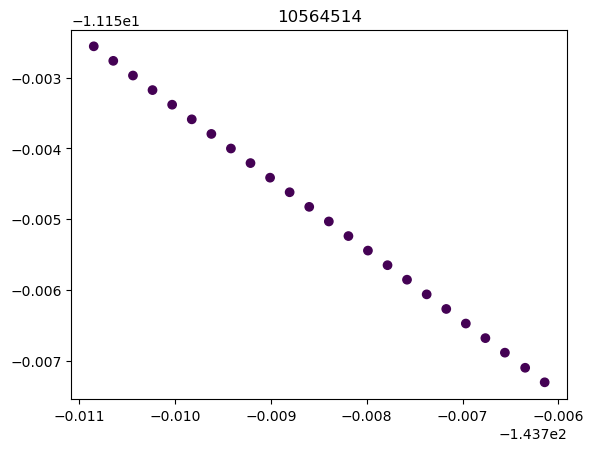

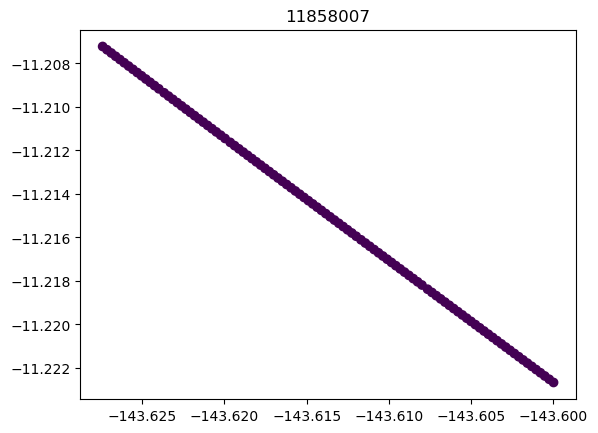

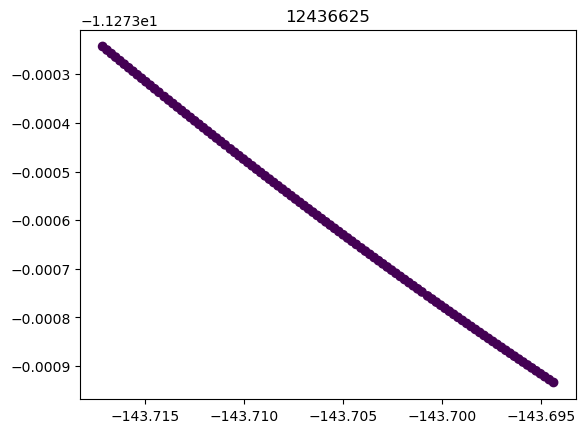

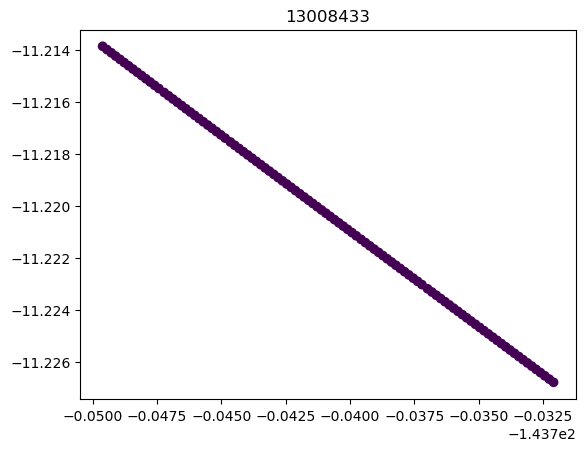

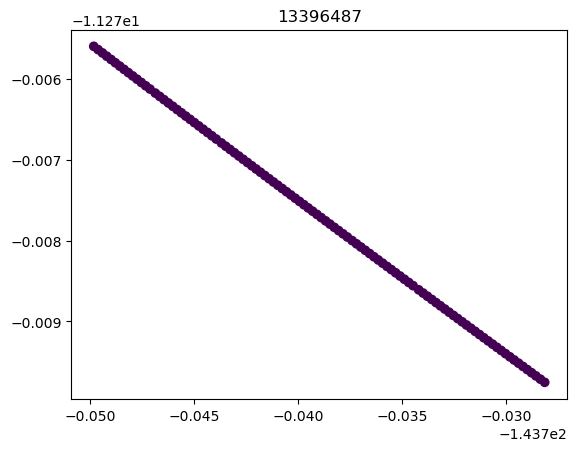

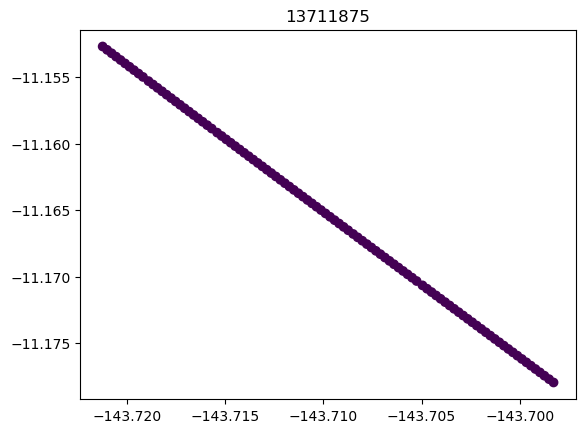

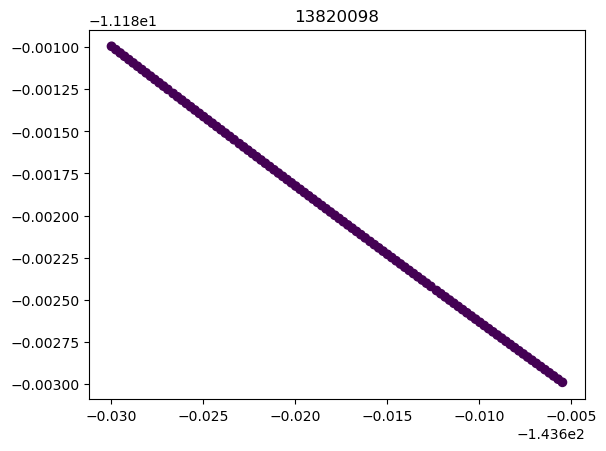

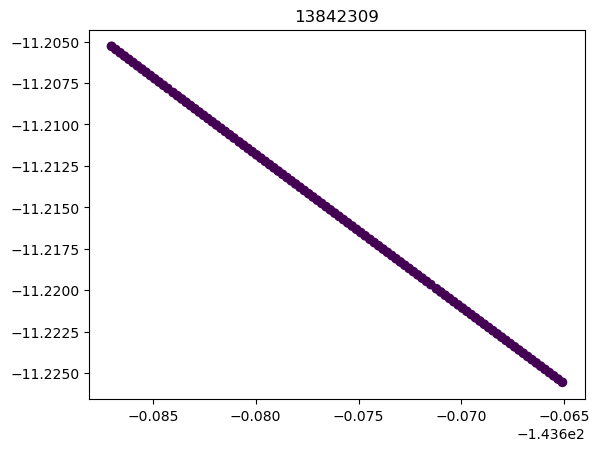

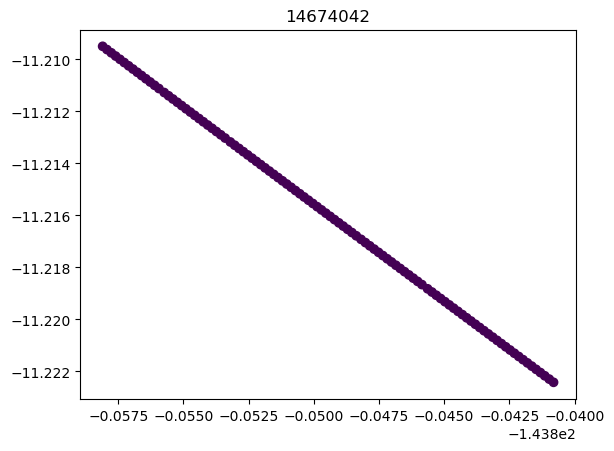

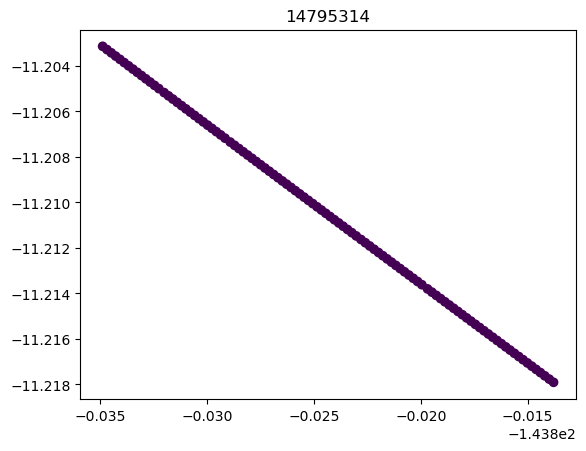

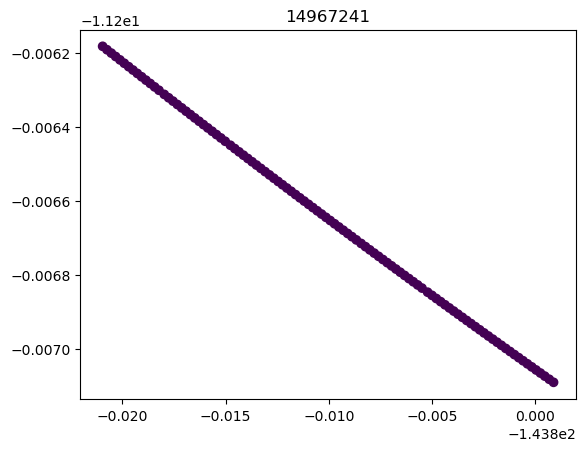

In [18]:
for o in pg_fakes.group_by("ORBITID").groups:
    plt.scatter(o['RA'], o['DEC'], c=o['H_VR'])
    plt.title(o[0]['ORBITID'])
    plt.show()

In [19]:
o = pg_fakes.group_by("ORBITID").groups[0]

In [26]:
o

RA,DEC,EXPNUM,CCDNUM,ORBITID,aei,mjd_mid,TDB,xv,H_VR,AMP,PERIOD,PHASE,d,observatory,r,MAG,type
float64,float64,int32,int64,int64,float64[6],float64,float64,float64[6],float64,float64,float64,float64,float64,float64[3],float64,float64,str8
-143.67888281817218,-11.204631450425246,845872,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.21447994315,19.254525066949327,-4.5010411303553655 .. -1.453173391303614,16.862270064643702,0.0,0.0,0.0,5.3753177090581925,-0.9723130239773092 .. -0.09252563558321852,4.447328732257841,23.754786918061548,asteroid
-143.67907705492908,-11.204599620346825,845873,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.21619125002,19.25452975225221,-4.501034702903089 .. -1.4531722652758097,16.862270064643702,0.0,0.0,0.0,5.375317938906762,-0.9723063207295254 .. -0.09253705087391721,4.447317565465467,23.754781558559387,asteroid
-143.6792787208863,-11.20456656445744,845874,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.21796780527,19.254534616195542,-4.501028030359378 .. -1.453171096306569,16.862270064643702,0.0,0.0,0.0,5.375318177518752,-0.9722993567140087 .. -0.09254890132897936,4.447305978027157,23.754775997196212,asteroid
-143.67947298177714,-11.204534714188318,845875,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.21967893464,19.2545393010123,-4.5010216035227355 .. -1.4531699703793453,16.862270064643702,0.0,0.0,0.0,5.375318407343073,-0.9722926441883359 .. -0.09256031528333111,4.447294822274961,23.754770643046925,asteroid
-143.6796676192937,-11.204502794002842,845876,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.22139319794,19.25454399440946,-4.501015164889914 .. -1.4531688423819533,16.862270064643702,0.0,0.0,0.0,5.37531863758813,-0.9722859144864211 .. -0.09257175006685092,4.447283650972544,23.754765281461232,asteroid
-143.67986247045158,-11.2044708304593,845877,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.2231091633,19.254548692466642,-4.501008719838969 .. -1.45316771325657,16.862270064643702,0.0,0.0,0.0,5.375318868061595,-0.9722791732233937 .. -0.09258319613091369,4.447272473480736,23.75475991693201,asteroid
-143.6800573365174,-11.204438856027021,845878,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.22482508671,19.254553390408773,-4.501002274920574 .. -1.4531665841508208,16.862270064643702,0.0,0.0,0.0,5.3753190985292205,-0.9722724272637077 .. -0.09259464183675381,4.447261301184432,23.754754554923522,asteroid
-143.68025308169328,-11.204406728731735,845879,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.226548581515,19.254558109080563,-4.500995801538541 .. -1.4531654500548246,16.862270064643702,0.0,0.0,0.0,5.375319330013585,-0.972265646659101 .. -0.09260613797159109,4.4472500845525405,23.754749171664187,asteroid
-143.68044692690563,-11.20437490461299,845880,5,10451789,5.3421973908749365 .. 15.558735994432258,58577.228255184666,19.25456278150523,-4.5009893915762005 .. -1.4531643270659935,16.862270064643702,0.0,0.0,0.0,5.375319559229006,-0.9722589277096986 .. -0.09261752136145085,4.447238982762821,23.75474384354893,asteroid


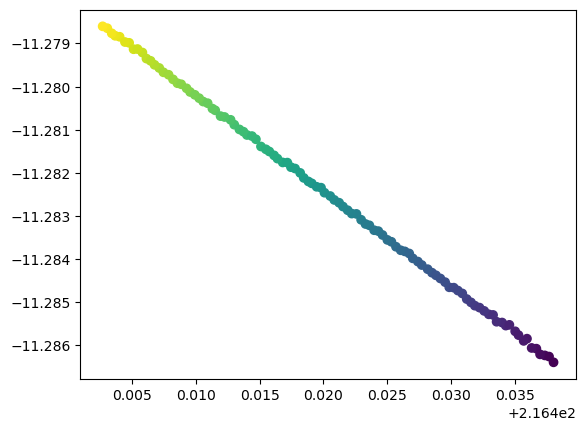

In [61]:
i = 0
result = search.results[i]
points = search.hough.X[result.close]
exposures = catalog.exposure[result.close]
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2])
plt.show()

In [46]:
import astropy.units as u

In [48]:
fake_coords = SkyCoord((pg_fakes['RA'] * u.deg).to(u.rad), (pg_fakes['DEC'] * u.deg).to(u.rad))
point_coords = SkyCoord((points[:, 0] * u.deg).to(u.rad), (points[:, 1] * u.deg).to(u.rad))

In [53]:
point_coords[0].separation(fake_coords).min()

<Angle 0.07291741 deg>

In [97]:
assignments = []
fake_proportions = []
for result in search.results:
    points = search.hough.X[result.close]    
    exposures = catalog.exposure[result.close]
    is_fake = []
    assignment = []
    for e, p in zip(exposures, points):
        # compute distance to fakes on this exposure
        f = pg_fakes[pg_fakes['EXPNUM'] == e]
        fake_coords = SkyCoord((f['RA'] * u.deg).to(u.rad), (f['DEC'] * u.deg).to(u.rad))
        point_coord = SkyCoord((p[0]*u.deg).to(u.rad), (p[1]*u.deg).to(u.rad))
        sep = point_coord.separation(fake_coords)
        min_idx = sep.argmin()
        min_sep = sep[min_idx]
        if min_sep < 1 * u.arcsec:
            is_fake.append(True)
            assignment.append(f[min_idx]['ORBITID'])
        else:
            is_fake.append(False)
            assignment.append(-1)

    is_fake = np.array(is_fake, dtype=bool)
    fake_proportion = (is_fake.sum()) / len(is_fake)
    assignments.append(assignment)
    fake_proportions.append(fake_proportion)
    

In [104]:
len(assignments[-1])

59

In [89]:
len(assignments[2])

12

In [105]:
fake_proportions

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]

In [280]:
def recover_fake(orbit_id, pg_fakes, points, results):
    search_separations = dict()
    search_detect = dict()
    result_separations = dict()
    result_detect = dict()
    
    fake = pg_fakes[pg_fakes['ORBITID'] == orbit_id]
    fake_coords = SkyCoord(fake['RA'] * u.deg, fake['DEC'] * u.deg)

    search_separations[orbit_id] = []
    search_detect[orbit_id] = 0

    result_separations[orbit_id] = [[] for result in results]
    result_detect[orbit_id] = [0 for result in results]
    
    for i, expnum in enumerate(fake['EXPNUM']):
        fake_point = fake[i]
        fake_coord = SkyCoord(fake_point['RA'] * u.deg, fake_point['DEC'] * u.deg)
        
        search_exposures = catalog.exposure
        search_mask = search_exposures == expnum
        search_points = points[search_mask]
        search_coords = SkyCoord(search_points[:, 0] * u.deg, search_points[:, 1] * u.deg)
        
        search_separation = fake_coord.separation(search_coords)
        search_match = (search_separation < match_threshold).sum()
        
        search_separations[orbit_id].append(search_separation)
        search_detect[orbit_id] += search_match
        for j, result in enumerate(results):
            
            result_mask = search_mask & result.close
            result_points = points[result_mask]
            result_coords = SkyCoord(result_points[:, 0] * u.deg, result_points[:, 1] * u.deg)
            result_separation = fake_coord.separation(result_coords)
            result_match = (result_separation < match_threshold).sum()

            result_separations[orbit_id][j].append(result_separation)
            result_detect[orbit_id][j] += result_match
            
    return search_separations, search_detect, result_separations, result_detect

In [278]:
import pickle
_ = pickle.dumps((orbit_id, pg_fakes, search.hough.X, search.results))

In [281]:
import joblib
recover_results = joblib.Parallel(
    n_jobs=48
)(
    joblib.delayed(recover_fake)(orbit_id, pg_fakes, search.hough.X, search.results)
    for orbit_id in set(pg_fakes['ORBITID'])
)

In [284]:
def merge_dicts(dicts):
    data = {}
    for d in dicts:
        data.update(d)
    return data

search_separations = merge_dicts([x[0] for x in recover_results])
search_detect = merge_dicts([x[1] for x in recover_results])
result_separations = merge_dicts([x[2] for x in recover_results])
result_detect = merge_dicts([x[3] for x in recover_results])
    

In [288]:
visits

[845872,
 845873,
 845874,
 845875,
 845876,
 845877,
 845878,
 845879,
 845880,
 845881,
 845882,
 845883,
 845884,
 845885,
 845886,
 845887,
 845888,
 845889,
 845890,
 845891,
 845892,
 845893,
 845894,
 845895,
 845896,
 845897,
 845898,
 845899,
 845900,
 845901,
 845902,
 845903,
 845904,
 845905,
 845906,
 845907,
 845908,
 845909,
 845910,
 845911,
 845912,
 845913,
 845914,
 845915,
 845916,
 845917,
 845918,
 845919,
 845920,
 845921,
 845922,
 845923,
 845924,
 845925,
 845926,
 845927,
 845928,
 845929,
 845930,
 845931,
 845932,
 845933,
 845934,
 845935,
 845936,
 845937,
 845938,
 845939,
 845940,
 845941,
 845942,
 845943,
 845944,
 845945,
 845946,
 845947,
 845948,
 845949,
 845950,
 845951,
 845952,
 845953,
 845954,
 845955,
 845956,
 845957,
 845958,
 845959,
 845960,
 845961,
 845962,
 845963,
 845964,
 845965,
 845966,
 845967,
 845968,
 845969,
 845970,
 845971,
 845972,
 845973,
 845974,
 845975]

In [286]:
search_detect

{10564514: 0,
 13711875: 90,
 13820098: 2,
 13842309: 0,
 13396487: 0,
 14967241: 1,
 10451789: 59,
 12436625: 0,
 14795314: 104,
 13008433: 31,
 11858007: 0,
 14674042: 0}

In [258]:
%%time
search_separations = {}
result_separations = {}
search_detect = {} # for each fake, this is the number of detections that matched across all exposures
result_detect = {} # for each fake and result, this is the number of detections that matched across all exposures
match_threshold = 1 * u.arcsec
for fake in pg_fakes.group_by("ORBITID").groups:
    orbit_id = fake[0]['ORBITID']
    fake_coords = SkyCoord(fake['RA'] * u.deg, fake['DEC'] * u.deg)

    search_separations[orbit_id] = []
    search_detect[orbit_id] = 0

    result_separations[orbit_id] = [[] for result in search.results]
    result_detect[orbit_id] = [0 for result in search.results]
    
    for i, expnum in enumerate(fake['EXPNUM']):
        fake_point = fake[i]
        fake_coord = SkyCoord(fake_point['RA'] * u.deg, fake_point['DEC'] * u.deg)
        
        search_exposures = catalog.exposure
        search_mask = search_exposures == expnum
        search_points = search.hough.X[search_mask]
        search_coords = SkyCoord(search_points[:, 0] * u.deg, search_points[:, 1] * u.deg)
        
        search_separation = fake_coord.separation(search_coords)
        search_match = (search_separation < match_threshold).sum()
        
        search_separations[orbit_id].append(search_separation)
        search_detect[orbit_id] += search_match
        for j, result in enumerate(search.results):
            
            result_mask = search_mask & result.close
            result_points = search.hough.X[result_mask]
            result_coords = SkyCoord(result_points[:, 0] * u.deg, result_points[:, 1] * u.deg)
            result_separation = fake_coord.separation(result_coords)
            result_match = (result_separation < match_threshold).sum()

            result_separations[orbit_id][j].append(result_separation)
            result_detect[orbit_id][j] += result_match

            
#     print(fake_coords)
#     search_points = search.hough.X
    
#     search_exposures = catalog.exposure
    
#     search_separations[orbit_id] = []
#     result_separations[orbit_id] = []
#     for i, fake_coord in enumerate(fake_coords):
#         expnum = fake[i]['EXPNUM']
#         exposure_mask = search_exposures == expnum
#         search_coords[exposure_mask]
#         search_sep = fake_coord.separation(search_coords)
#         search_separations[orbit_id].append(search_sep)
#         result_separations[orbit_id].append([])
#         for result in search.results:
#             result_points = search.hough.X[result.close & exposure_mask]
#             result_coords = SkyCoord(result_points[:, 0] * u.deg, result_points[:, 1] * u.deg)            
#             result_sep = fake_coord.separation(result_exposure_coord)
#             result_separations[orbit_id][-1].append(result_sep)
# #             result_epoch_matches.append(result_sep.argmin())
            

CPU times: user 50.4 s, sys: 242 ms, total: 50.7 s
Wall time: 50.6 s


In [262]:
search_detect

{10451789: 59,
 10564514: 0,
 11858007: 0,
 12436625: 0,
 13008433: 31,
 13396487: 0,
 13711875: 90,
 13820098: 2,
 13842309: 0,
 14674042: 0,
 14795314: 104,
 14967241: 1}

In [263]:
result_detect

{10451789: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59],
 10564514: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 11858007: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 12436625: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 13008433: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 13396487: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 13711875: [0, 0, 0, 0, 0, 0, 0, 0, 0, 90, 0, 0],
 13820098: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 13842309: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 14674042: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 14795314: [0, 0, 104, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 14967241: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [261]:
# result_separations[14795314][2]

[<Angle [5.37014768e-05] deg>,
 <Angle [4.99812566e-05] deg>,
 <Angle [5.1840016e-05] deg>,
 <Angle [4.28448976e-05] deg>,
 <Angle [4.53682506e-05] deg>,
 <Angle [2.47359444e-05] deg>,
 <Angle [3.80980257e-05] deg>,
 <Angle [2.69034643e-05] deg>,
 <Angle [4.91651112e-05] deg>,
 <Angle [2.64783256e-05] deg>,
 <Angle [2.55079059e-05] deg>,
 <Angle [5.46239151e-05] deg>,
 <Angle [1.37339889e-05] deg>,
 <Angle [7.06917612e-06] deg>,
 <Angle [2.40099842e-05] deg>,
 <Angle [5.07508745e-05] deg>,
 <Angle [5.12440858e-05] deg>,
 <Angle [1.00370509e-05] deg>,
 <Angle [3.87397042e-05] deg>,
 <Angle [3.82325636e-05] deg>,
 <Angle [6.79800126e-05] deg>,
 <Angle [4.902466e-05] deg>,
 <Angle [3.28187501e-05] deg>,
 <Angle [2.78664463e-05] deg>,
 <Angle [3.36261951e-05] deg>,
 <Angle [3.72706892e-05] deg>,
 <Angle [4.69468897e-05] deg>,
 <Angle [0.00010896] deg>,
 <Angle [7.34173679e-05] deg>,
 <Angle [2.51136146e-05] deg>,
 <Angle [5.89628701e-05] deg>,
 <Angle [3.53005882e-05] deg>,
 <Angle [5.4873

In [228]:
search_separations[10451789][0] < 1 * u.arcsec

array([False, False, False, ..., False, False, False])

In [202]:
pg_fakes[pg_fakes['ORBITID'] == 10451789]['MAG']

23.754786918061548
23.754781558559387
23.754775997196212
23.754770643046925
23.754765281461232
23.75475991693201
23.754754554923522
23.754749171664187
23.75474384354893
23.754738486824007
23.754733157875023


In [230]:
search_detection_rates = {}
result_detection_rates = {}
for orbit_id in search_separations:
    search_detect = 0
    for search_sep in search_separations[orbit_id]:
        search_detect += (search_sep < 1 * u.arcsec).sum()
    search_detection_rates[orbit_id] = search_detect
    result_detection_rates[orbit_id] = []
    result_seps = result_separations[orbit_id]
    for result_sep in result_seps:
        result_detect = 0
        for sep in result_sep:
            result_detect += (sep < 1 * u.arcsec).sum()
        result_detection_rates[orbit_id].append(result_detect)

In [231]:
search_detection_rates

{10451789: 165,
 10564514: 0,
 11858007: 0,
 12436625: 0,
 13008433: 87,
 13396487: 0,
 13711875: 92,
 13820098: 4,
 13842309: 0,
 14674042: 0,
 14795314: 262,
 14967241: 6}

In [217]:
search_separations[14795314]

<Angle [0.0335154 , 0.0133519 , 0.07435047, ..., 0.25931247, 0.26337853,
        0.2759025 ] deg>

In [232]:
for orbit_id in search_detection_rates:
    print(orbit_id, search_detection_rates[orbit_id], result_detection_rates[orbit_id])

10451789 165 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
10564514 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11858007 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
12436625 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [205]:
def plot_fake(o):
    r = pg_fakes[pg_fakes['ORBITID'] == o]
    
    coord = (SkyCoord(r['RA'] * u.deg, r['DEC'] * u.deg))
    plt.scatter(coord.ra, coord.dec, c=r['TDB'])
    plt.title(str(o) + " VR~" + str(r['H_VR'][0]))


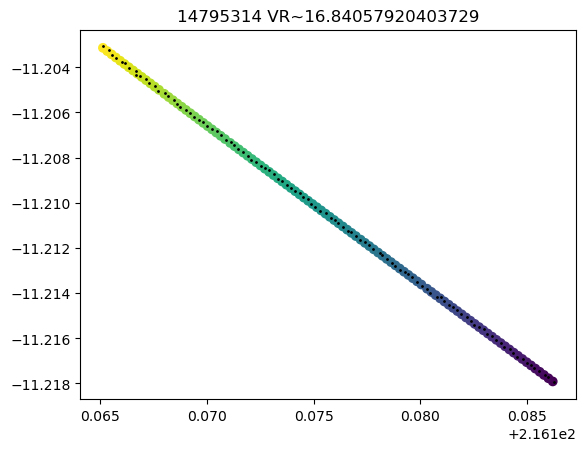

In [214]:
i = 2
result = search.results[i]
points = search.hough.X[result.close]
exposures = catalog.exposure[result.close]
plot_fake(14795314)
plt.scatter(points[:, 0], points[:, 1], c="k", s=1)#points[:, 2])
plt.show()

In [188]:
result_detection_rates[10451789]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

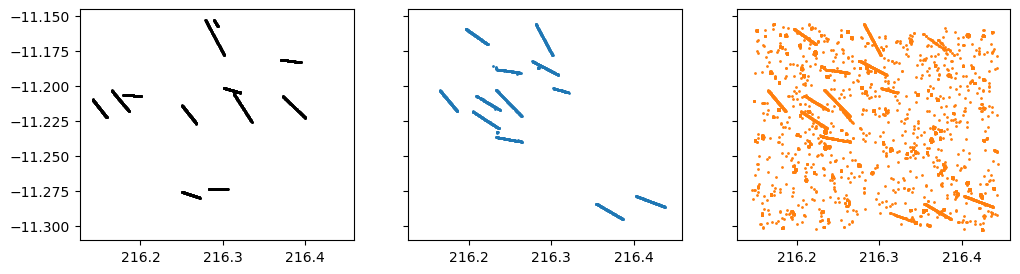

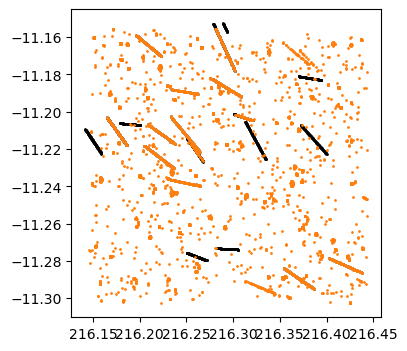

In [166]:
# for each fake, calculate its separation to all of the results points and all of the search points
# if there is a cluster at low separation in the points, it was detectable
# if there is a cluster at low separation in the results, it was found

fig = plt.figure(figsize=(12, 3))
axs = fig.subplots(1, 3, sharey=True, sharex=True)
ax = axs[0]
plt.sca(ax)
for fake in pg_fakes.group_by("ORBITID").groups:
    coord = (SkyCoord(fake['RA'] * u.deg, fake['DEC'] * u.deg))
    plt.scatter(coord.ra, coord.dec, c="k", s=1)#, label=f"VR~{fake['H_VR'][0]:.1f}")

# plt.legend()
ax = axs[1]
plt.sca(ax)
for result in search.results:
    points = search.hough.X[result.close]
    exposures = catalog.exposure[result.close]
    coord = (SkyCoord(points[:, 0] * u.deg, points[:, 1] * u.deg))
    plt.scatter(coord.ra, coord.dec, c='C0', s=1)
    
ax = axs[2]
plt.sca(ax)
points = search.hough.X
coord = (SkyCoord(points[:, 0] * u.deg, points[:, 1] * u.deg))
plt.scatter(coord.ra, coord.dec, c='C1', s=1)
    
plt.show()

fig = plt.figure(figsize=(4, 4))
ax = fig.subplots(1, 1, sharey=True, sharex=True)
plt.sca(ax)
for fake in pg_fakes.group_by("ORBITID").groups:
    coord = (SkyCoord(fake['RA'] * u.deg, fake['DEC'] * u.deg))
    plt.scatter(coord.ra, coord.dec, c="k", s=1)#, label=f"VR~{fake['H_VR'][0]:.1f}")

for result in search.results:
    points = search.hough.X[result.close]
    exposures = catalog.exposure[result.close]
    coord = (SkyCoord(points[:, 0] * u.deg, points[:, 1] * u.deg))
    plt.scatter(coord.ra, coord.dec, c='C0', s=1)

points = search.hough.X
coord = (SkyCoord(points[:, 0] * u.deg, points[:, 1] * u.deg))
plt.scatter(coord.ra, coord.dec, c='C1', s=1)


In [115]:
assignments[-1][0]

10451789

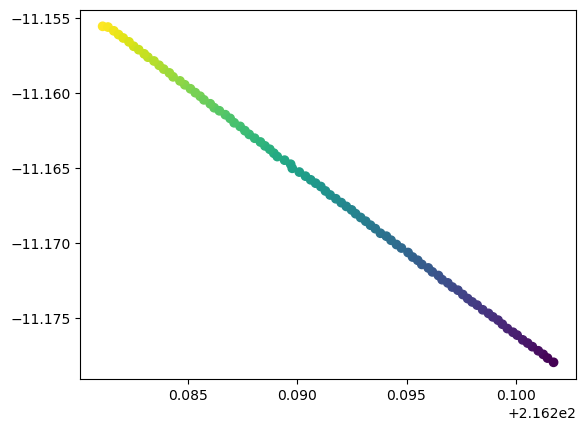

13711875

In [124]:
i = -3
result = search.results[i]
points = search.hough.X[result.close]
exposures = catalog.exposure[result.close]
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2])
plt.show()
assignments[i][0]

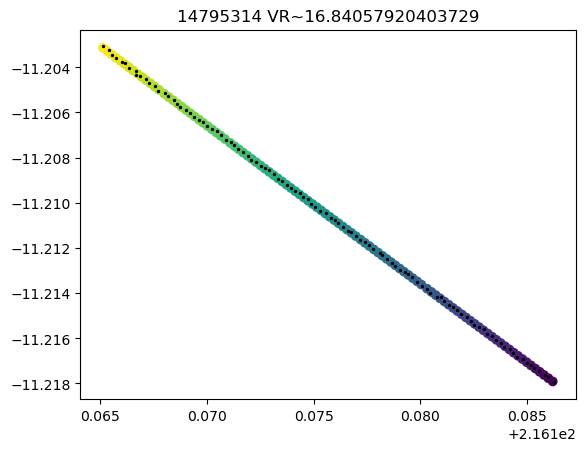

In [132]:
def plot_fake(o):
    r = pg_fakes[pg_fakes['ORBITID'] == o]
    
    coord = (SkyCoord(r['RA'] * u.deg, r['DEC'] * u.deg))
    plt.scatter(coord.ra, coord.dec, c=r['TDB'])
    plt.title(str(o) + " VR~" + str(r['H_VR'][0]))
    

i = 2
plot_fake(assignments[i][0])
result = search.results[i]
points = search.hough.X[result.close]
exposures = catalog.exposure[result.close]
coord = (SkyCoord(points[:, 0] * u.deg, points[:, 1] * u.deg))
plt.scatter(coord.ra, coord.dec, c='k', s=2)
plt.show()

In [32]:
search.hough.M.shape

(507, 7539, 2)

845876
845939
845881
845900
845924
845927
845899
845923
845945
845952
845883
